In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Resumo

**Analistas de Dados**
<br> Seu trabalho vai ser entender o perfil de fraude

*júnior*
- <span style="color: gray;">Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!</span>
- <span style="color: gray;">Como estão esses nossos KPIs atualmente?</span>
- <span style="color: gray;">Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer</span>
- <span style="color: gray;">Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc</span>
- Agora entenda o perfil do fraudador. Veja cada feature em relação aos fraudadores x não fraudadores. Use e abuse de correlações, testes de hipótese, etc
- <s>Faça um PowerBI ou Looker com os principais KPIs e gráficos que geram insights nesse tema</s>

*pleno*
- Use alguns algoritmos para melhor entendimento do perfil de fraude, como regressão logística ou algum outro que achar válido

*sênior*
- Construa “regras duras” para evitarmos fraude sem o uso de machine learning. Aqui são regras mesmo, por exemplo, se valor acima de X então barramos uma transação
- Discuta os prós e contras dessa sua estratégia
- Simule perdas e ganhos da estratégia
- Desenhe um teste AB para testarmos sua estratégia

**Cientistas de Dados**
<br> Seu trabalho vai ser criar um modelo preditivo para fraude para auxiliar no aumento do lucro

*júnior*
- Façam uma EDA - Análise exploratória de dados. Podem se basear nas perguntas do analista para isso
- Desenvolva um modelo para predizer a variável Fraude (1-Sim, 0-Não). Quais técnicas testou? Qual selecionou como melhor abordagem? Explique!
- Compare o desempenho do seu algoritmo com o desempenho de um modelo anterior, cujo resultado é encontrado na coluna Score_fraude_modelo do dataset. Quais métricas usou e qual sua conclusão?
- Queremos encontrar o ponto de threshold ideal para o modelo já treinado apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o mais alto). Defina o ponto de corte que maximize os lucros da empresa, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

*pleno*
- Como você pode garantir que o desempenho do modelo no laboratório vai ser um proxy para o desempenho do modelo em produção?
- Supondo que o desempenho produtivo seja muito diferente do esperado, quais você acha que são as causas mais prováveis?
- Se o modelo precisar responder online, no menor tempo possível, o que isso mudaria no desenvolvimento do seu modelo?

<s>*sênior - projeto de alto impacto - ML Engineers*</s>

<s>Para aqueles que estão buscando vagas mais sênior ou realmente um projeto que destaque MUITO você. Minha dica é fazer isso se você já tiver estudado machine learning muito bem e já possa partir para conceitos de deploy 👇</s>
- <s>Use ferramentas como o MLFlow para testes</s>
- <s>Simule um deploy do modelo. Use Docker, Kuberneters, AWS, etc. Tudo que achar necessário para fazer o deploy</s>
- <s>Pense no monitoramento do modelo</s>

<span style="color: red">***Notas importante***</span>

- Pra fins desse case os dados são anonimizados propositadamente. Para resolvê-lo, vocês vão precisar fazer algumas suposições. Justifique toda suposição que fizer
- Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento.

***Dados***

- **score_1** a **score_10**: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre
- **País**: pais de compra
- **Produto:** produto que está sendo comprado no e-commerce
- **Categoria_produto**: categoria a qual esse produto se encaixa
- **Entrega_doc_1** a **entrega_doc_3**: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou
- **Score_fraude_modelo**: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude
- **Fraude**: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

<span style="color: gray;"> linha cinza</span> signifca **FEITO**<br>
<s> linha sublinhada</s> signifca que **não** vou fazer por enquanto

### **Cleaning** and **Modeling**

In [3]:

df = pd.read_csv('../../data/09. TCC/fraude/dados - dados.csv')
cols = list(df.columns)
cols.sort()
df = df[cols].copy()

df['datahora_compra'] = pd.to_datetime(df['data_compra'])
df['data_compra'] = df['datahora_compra'].dt.date
df['entrega_doc_2'] = df['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)
df['entrega_doc_3'] = df['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)

## corrigindo produtos com duas ou mais categorias, sua categoria oficial é a que mais aparece
df_qtde_categorias_produto = df.groupby('produto')['categoria_produto'].nunique().reset_index(name='qtde_categ')
df_qtde_categorias_produto = df_qtde_categorias_produto[df_qtde_categorias_produto['qtde_categ'] > 1]
for produto in df_qtde_categorias_produto['produto'].unique(): 
    df_qtde_categorias_produto = df[df['produto'] == produto].copy()

    oficial_categ = df_qtde_categorias_produto['categoria_produto'].value_counts().sort_values().index[-1]
    produto_indexes = df_qtde_categorias_produto.index
    df.loc[produto_indexes, 'categoria_produto'] = oficial_categ

## nivelando categoria de produtos
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos categorias para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de categorias com niveis altos em média acontecem com mais frequencia que niveis baixos.
# semelhante a pareto:
#    A: 1°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
df['categ_nivel'] = None

df_categ_freqs = df['categoria_produto'].value_counts().reset_index(name='frequencia')
df_categ_freqs['proporcao_frequencia_acumulada'] = df_categ_freqs['frequencia'].cumsum()/df_categ_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    categs = df_categ_freqs[(df_categ_freqs['proporcao_frequencia_acumulada'] > lower) & (df_categ_freqs['proporcao_frequencia_acumulada'] <= upper)]['categoria_produto']

    df.loc[df['categoria_produto'].isin(categs), 'categ_nivel'] = nivel
# df = df.drop('categoria_produto', axis=1)

## nivelando produtos (só para produtos que tem mais que uma compra, caso contrario produto terá nivel E)
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos produtos para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de produtos com niveis altos em média acontecem com mais frequencia que niveis baixos.]
# semelhante a pareto: **(só para produtos que tem mais que uma compra)**
#    A: 1°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
df['prod_nivel'] = None

df_prod_freqs = df['produto'].value_counts().reset_index(name='frequencia')
df_prod_freqs = df_prod_freqs[df_prod_freqs['frequencia'] > 1].copy()
df_prod_freqs['proporcao_frequencia_acumulada'] = df_prod_freqs['frequencia'].cumsum()/df_prod_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    prods = df_prod_freqs[(df_prod_freqs['proporcao_frequencia_acumulada'] > lower) & (df_prod_freqs['proporcao_frequencia_acumulada'] <= upper)]['produto']

    df.loc[df['produto'].isin(prods), 'prod_nivel'] = nivel
df['prod_nivel'] = df['prod_nivel'].fillna('E')
# df = df.drop('produto', axis=1)

df['periodo'] = df['datahora_compra'].dt.to_period('M')
# df['dia_compra'] = df['datahora_compra'].dt.day    ## não existe dados suficientes (por exemplo, dia 7 de 2010 até 2025) para essa feature ser importante
# df['mes_compra'] = df['datahora_compra'].dt.month  ## não existe dados suficientes (por exemplo, mês 4 de 2010 até 2025) para essa feature ser importante
# df['ano_compra'] = df['datahora_compra'].dt.year   ## não existe dados suficientes (por exemplo, 2010 até 2025) para essa feature ser importante
df['dia_semana_compra'] = df['datahora_compra'].dt.day_name()
df['periodo_dia_compra'] = df['datahora_compra'].dt.hour.apply(lambda x: 'Dawn' if x >= 0 and x < 6 else 'Morning' if x >= 6 and x < 12 else 'Afternoon' if x >= 12 and x < 18 else 'Night' if x >= 18 and x <= 23 else None)

df['pais'] = df['pais'].apply(lambda x: x if str(x) != 'nan' else df['pais'].sample(random_state=42).values[0])
df['pais'] = df['pais'].apply(lambda x: 'Others' if x not in ['BR','AR','UY','US'] else x) # ['BR','AR','UY','US'] são os top 4 paises com mais compras

# "Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento."
df['ganho'] = df[['valor_compra','fraude']].apply(lambda x: (x['valor_compra']*.1 if not x['fraude'] else x['valor_compra']*-1), axis=1)

df = df.sort_values(by='data_compra')

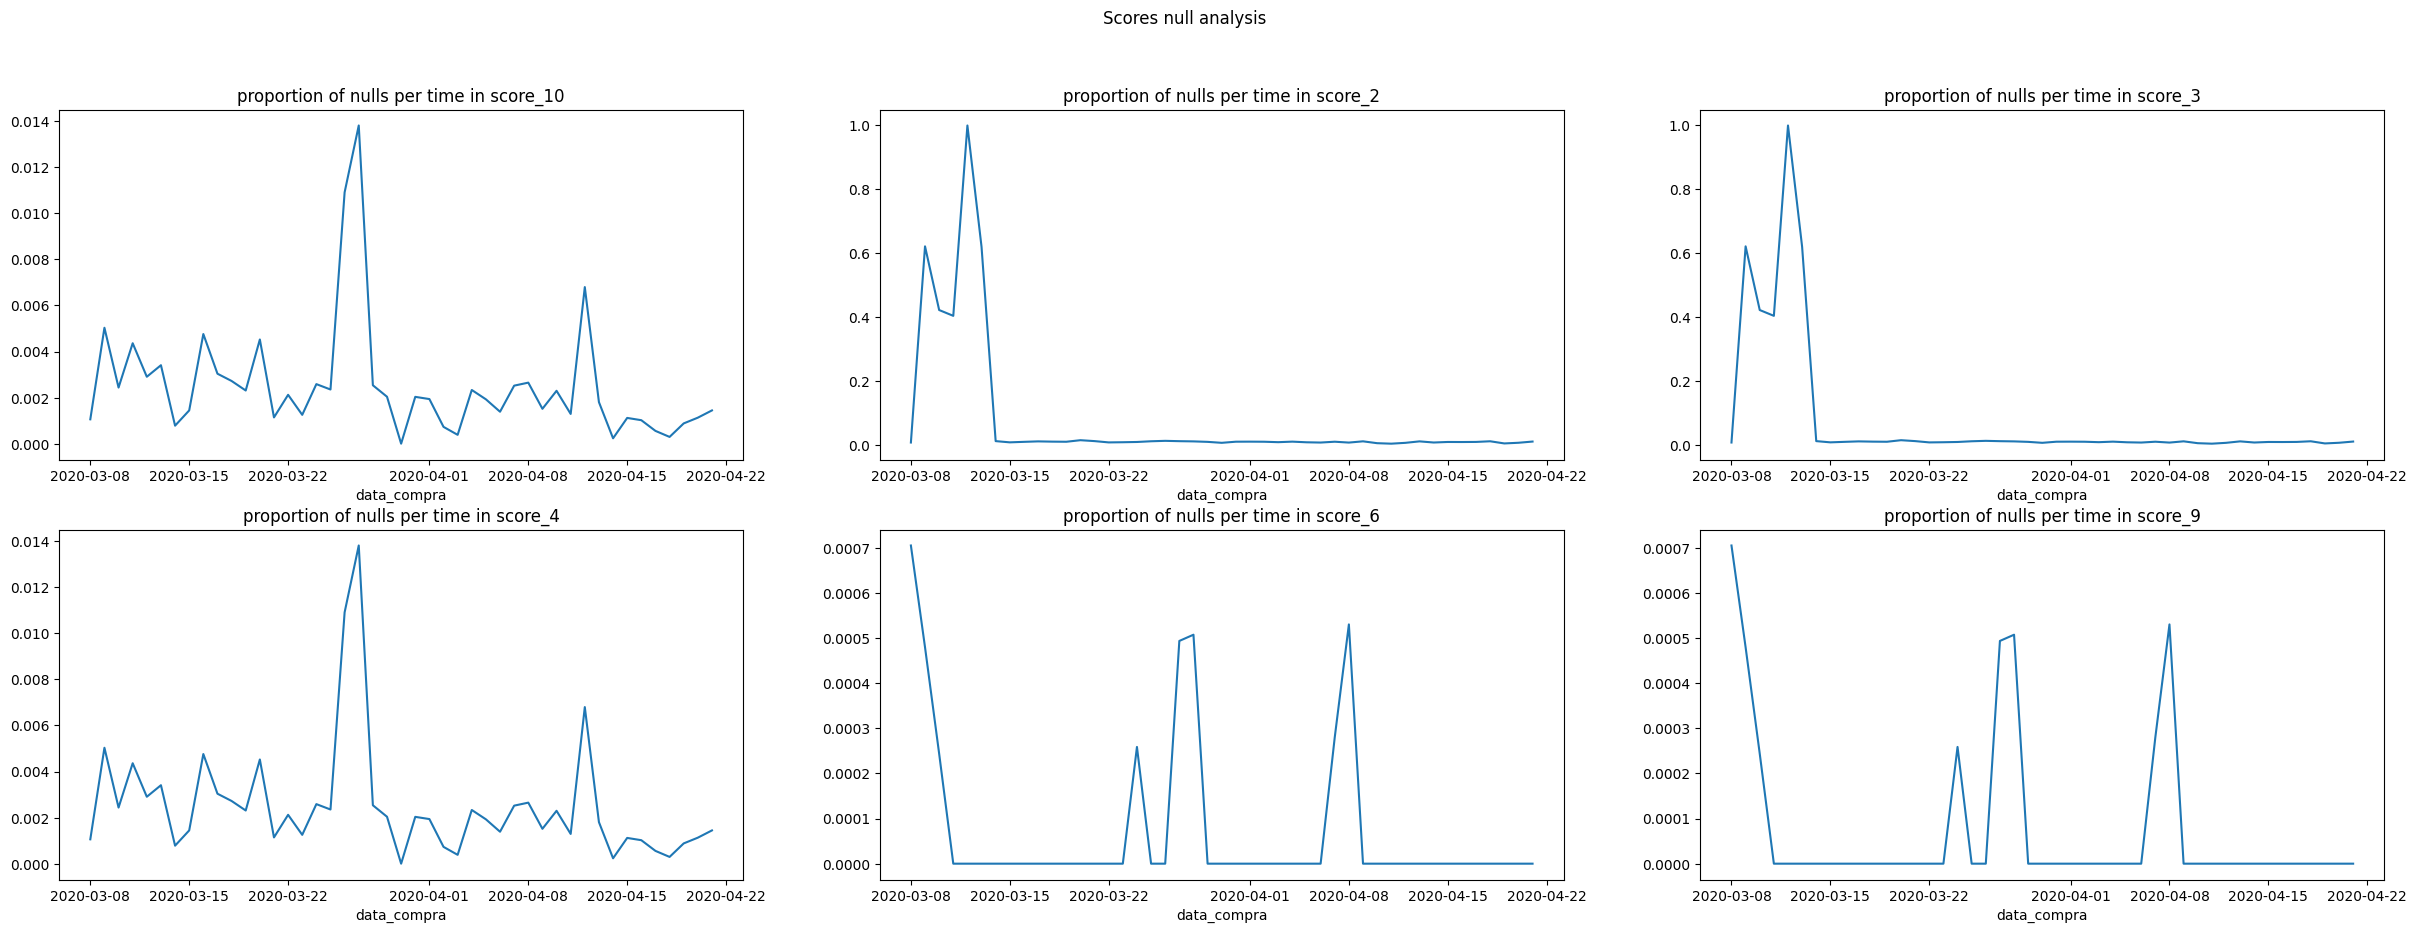

score nulls:


score_10      365
score_2     12984
score_3     12984
score_4       365
score_6        11
score_9        11
dtype: int64

score_10    365
score_4     365
dtype: int64

score_2    12984
score_3    12984
dtype: int64

score_6    11
score_9    11
dtype: int64

In [4]:

fig, ax = plt.subplots(2, 3, figsize=(30, 10))

score_with_null_cols = [col for col in df.columns if 'score' in col and 'modelo' not in col and df[col].isna().sum() > 0]
for i, col in enumerate(score_with_null_cols):
    x_pos = i//3
    y_pos = i%3

    df.groupby('data_compra')[col].apply(lambda x: len([x_i for x_i in x if str(x_i) == 'nan'])/len(x) ).plot.line(ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(f'proportion of nulls per time in {col}')

plt.suptitle(f'Scores null analysis')
plt.show()

print('score nulls:')
display(df[score_with_null_cols].isna().sum())
display(df[df['score_10'].isna()][['score_10','score_4']].isna().sum())
display(df[df['score_2'].isna()][['score_2','score_3']].isna().sum())
display(df[df['score_6'].isna()][['score_6','score_9']].isna().sum())

In [5]:
... # ideia: scores nulos poderiam ser preenchidos usando algum algoritmo de inferencia (ML) dado as features: entrega_doc_1, entrega_doc_2, ... (necessario analise para saber se existe relações com o score a ser preenchido)

Ellipsis

In [6]:

### fillna com valores aleatórios dado sua distribuição.
# aqui partimos da suposição de que os dados disponiveis não tem relações com os scores, sendo assim impossivel de fazer inferencia usando ML ou outra coisa... logo preencheremos os valores nulos respeitando a distribuição origem do valor. 
# colunas com nulos possuem muito mais valores com não nulos do que nulos ~ OK.
for score_col in score_with_null_cols:
    df[score_col] = df[score_col].apply(lambda x: x if str(x) != 'nan' else df[score_col].sample(random_state=42).values[0])

df

,categoria_produto,data_compra,entrega_doc_1,entrega_doc_2,entrega_doc_3,fraude,pais,produto,score_1,score_10,...,score_9,score_fraude_modelo,valor_compra,datahora_compra,categ_nivel,prod_nivel,periodo,dia_semana_compra,periodo_dia_compra,ganho
92564,cat_903baa4,2020-03-08,0,0,0,0,BR,Base Para Prato Em Mdf Cru 3mm 35cm Kit Com 75...,4,403.0,...,404.0,79,33.12,2020-03-08 08:12:53,D,E,2020-03,Sunday,Morning,3.312
72049,cat_75a6330,2020-03-08,1,0,0,0,BR,Jbl T290 Fones De Ouvido Intra- Fones De Ouvid...,1,4.0,...,434.0,87,16.16,2020-03-08 18:22:40,B,E,2020-03,Sunday,Night,1.616
50901,cat_0eb83e7,2020-03-08,1,1,1,0,BR,Bateria Moto Moura 12v-5ah Honda 125/150 Biz/f...,4,206.0,...,1904.0,49,33.88,2020-03-08 08:09:34,A,B,2020-03,Sunday,Morning,3.388
88250,cat_f0ec611,2020-03-08,1,0,1,0,BR,Camiseta Gw Shiryu Cavaleiros Do Zodíaco Dese...,4,827.0,...,4196.0,67,12.20,2020-03-08 21:26:06,A,E,2020-03,Sunday,Night,1.220
64370,cat_1411a76,2020-03-08,1,0,1,0,BR,Calibre De Folga C/17 Laminas ( Contém A Lamin...,4,191.0,...,5850.0,10,3.12,2020-03-08 16:32:39,D,E,2020-03,Sunday,Afternoon,0.312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131711,cat_64b574b,2020-04-21,0,0,0,0,BR,Máscara Proteção Facial Clean Para Dentistas A...,4,0.0,...,0.0,92,16.58,2020-04-21 16:22:54,B,E,2020-04,Tuesday,Afternoon,1.658
60878,cat_d69bed9,2020-04-21,0,0,0,0,BR,2x Body Pack Explosive 44 Packs - Body Action,4,302.0,...,304.0,57,28.91,2020-04-21 19:34:50,A,E,2020-04,Tuesday,Night,2.891
143900,cat_09d1cd6,2020-04-21,1,0,1,0,BR,"Cama Elastica Pula Pula Trampolim Infantil 1,4...",4,201.0,...,4435.0,12,76.99,2020-04-21 11:23:47,B,E,2020-04,Tuesday,Morning,7.699
22365,cat_9bacaa5,2020-04-21,1,0,1,0,BR,Botina Roça Couro Legitimo Texana Country Comb...,4,767.0,...,4451.0,60,27.00,2020-04-21 10:04:35,A,E,2020-04,Tuesday,Morning,2.700


### **EDA** ~ analise univaridada e bivariada

In [7]:

print(df.shape)
print(f"data date range: {df['datahora_compra'].min()} to {df['datahora_compra'].max()} ~ {(df['datahora_compra'].max()-df['datahora_compra'].min())} of data")
print('target col: <fraude>')
print('leak for target col: <score_fraude_modelo>')
print('* no rows with nulls was deleted')
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(150000, 27)
data date range: 2020-03-08 00:02:15 to 2020-04-21 23:59:56 ~ 44 days 23:57:41 of data
target col: <fraude>
leak for target col: <score_fraude_modelo>
* no rows with nulls was deleted


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
categoria_produto,object,0,0.0,8314,"[cat_903baa4, cat_75a6330, cat_0eb83e7]"
data_compra,object,0,0.0,45,"[2020-03-08, 2020-03-09, 2020-03-10]"
entrega_doc_1,int64,0,0.0,2,"[0, 1]"
entrega_doc_2,int64,0,0.0,2,"[0, 1]"
entrega_doc_3,int64,0,0.0,2,"[0, 1]"
fraude,int64,0,0.0,2,"[0, 1]"
pais,object,0,0.0,5,"[BR, AR, Others]"
produto,object,0,0.0,127804,[Base Para Prato Em Mdf Cru 3mm 35cm Kit Com 7...
score_1,int64,0,0.0,4,"[4, 1, 2]"
score_10,float64,0,0.0,1793,"[403.0, 4.0, 206.0]"


#### **Univariate** analisys

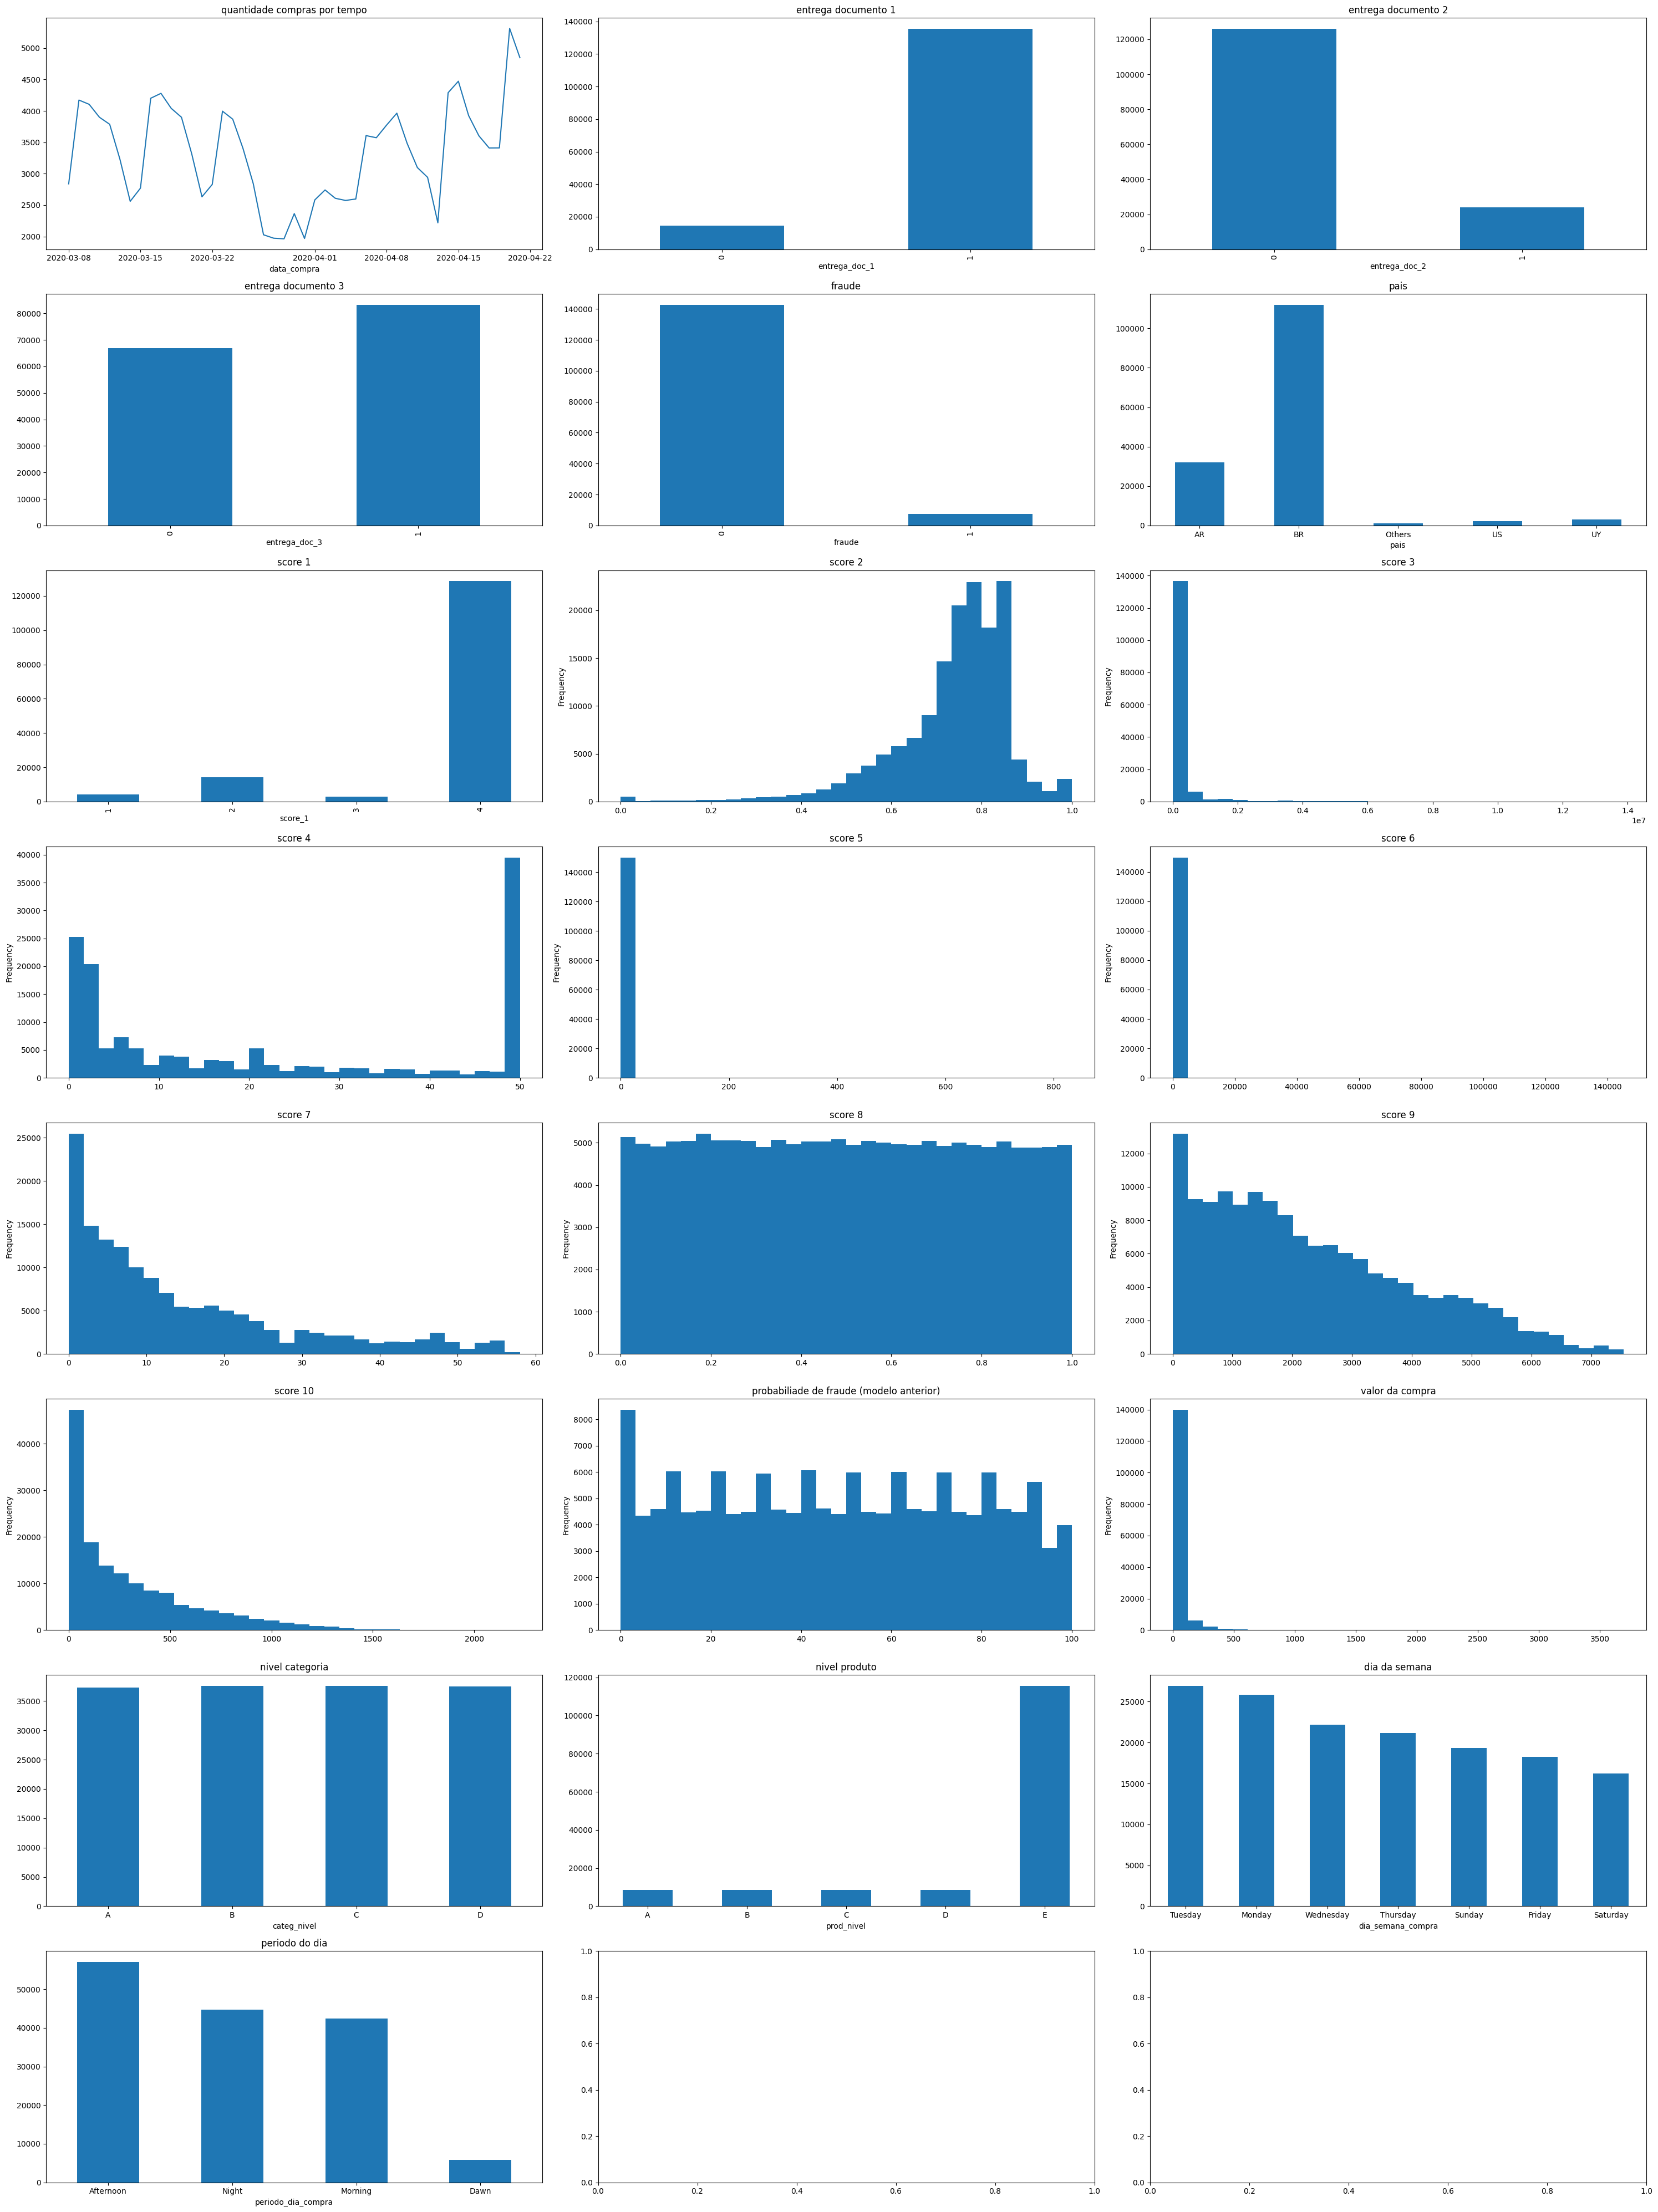

In [8]:

lines = 8
columns = 3
fig, axs = plt.subplots(lines, columns, figsize=(30, 5*lines))

df.groupby('data_compra')['valor_compra'].count().plot.line(ax=axs[0, 0])
axs[0, 0].set_title('quantidade compras por tempo')

df['entrega_doc_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('entrega documento 1')

df['entrega_doc_2'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[0, 2])
axs[0, 2].set_title('entrega documento 2')

df['entrega_doc_3'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 0])
axs[1, 0].set_title('entrega documento 3')

df['fraude'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('fraude')

df['pais'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[1, 2])
axs[1, 2].tick_params(axis='x', labelrotation=0)
axs[1, 2].set_title('pais')

df['score_1'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[2, 0])
axs[2, 0].set_title('score 1')

df['score_2'].plot.hist(bins=30, ax=axs[2, 1])
axs[2, 1].set_title('score 2')

df['score_3'].plot.hist(bins=30, ax=axs[2, 2])
axs[2, 2].set_title('score 3')

df['score_4'].plot.hist(bins=30, ax=axs[3, 0])
axs[3, 0].set_title('score 4')

df['score_5'].plot.hist(bins=30, ax=axs[3, 1])
axs[3, 1].set_title('score 5')

df['score_6'].plot.hist(bins=30, ax=axs[3, 2])
axs[3, 2].set_title('score 6')

df['score_7'].plot.hist(bins=30, ax=axs[4, 0])
axs[4, 0].set_title('score 7')

df['score_8'].plot.hist(bins=30, ax=axs[4, 1])
axs[4, 1].set_title('score 8')

df['score_9'].plot.hist(bins=30, ax=axs[4, 2])
axs[4, 2].set_title('score 9')

df['score_10'].plot.hist(bins=30, ax=axs[5, 0])
axs[5, 0].set_title('score 10')

df['score_fraude_modelo'].plot.hist(bins=30, ax=axs[5, 1])
axs[5, 1].set_title('probabiliade de fraude (modelo anterior)')

df['valor_compra'].plot.hist(bins=30, ax=axs[5, 2])
axs[5, 2].set_title('valor da compra')

df['categ_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 0])
axs[6, 0].set_title('nivel categoria')
axs[6, 0].tick_params(axis='x', labelrotation=0)

df['prod_nivel'].value_counts(normalize=False).sort_index().plot.bar(ax=axs[6, 1])
axs[6, 1].set_title('nivel produto')
axs[6, 1].tick_params(axis='x', labelrotation=0)

df['dia_semana_compra'].value_counts(normalize=False).plot.bar(ax=axs[6, 2])
axs[6, 2].set_title('dia da semana')
axs[6, 2].tick_params(axis='x', labelrotation=0)

df['periodo_dia_compra'].value_counts(normalize=False).plot.bar(ax=axs[7, 0])
axs[7, 0].set_title('periodo do dia')
axs[7, 0].tick_params(axis='x', labelrotation=0)

# plt.suptitle('Univariate analisys')
plt.tight_layout()
plt.show()

*insights:*
- **quantidade de compras por tempo:** apresentou tendencia nula e sazonalidade entre 08/03 até 26/03, depois disso apresentou tendencia positiva e falta de sazonalidade.
- **entrega de documentos:** (1) mais comum apresentar; (2) mais comum não apresentar; (3) apresentar ou não apresentar é balanceado.
- **fraude:** existem pouquissimas fraudes.
- **país:** existe pouco mais que 50 paises que compraram, sendo assim BR o top 1 disparado, AR como top 2.
- **scores:** cada um possui uma distribuição em particular, scores 3,5 e 6 possuem outliers "pesados".
- **modelo anterior para fraude:** bem balanceado em sua inferencia, oq pode significar que o modelo era ruim pois existem pouquissimas fraudes nos dados.
- **valor de compra:** em grande parte possui baixo valor. possui outliers "pesados".
- **nivel de categoria:** balanceado *(definição dos niveis de categoria foram definidos em **Cleaning** and **Modeling**)*.
- **nivel de produtos:** balanceado para niveis diferente de E *(definição dos niveis de produtos foram definidos em **Cleaning** and **Modeling**)*.
- **dia da semana:** as compras acontecem com mais frequencia no começo da semana (a partir de segunda-feira).
- **periodo do dia:** as compras acontecem com mais frequencia no inicio do dia (a partir da manhã).

###### *Respondido:* Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc

#### **Bivariate** analisys ~ versus *fraude*

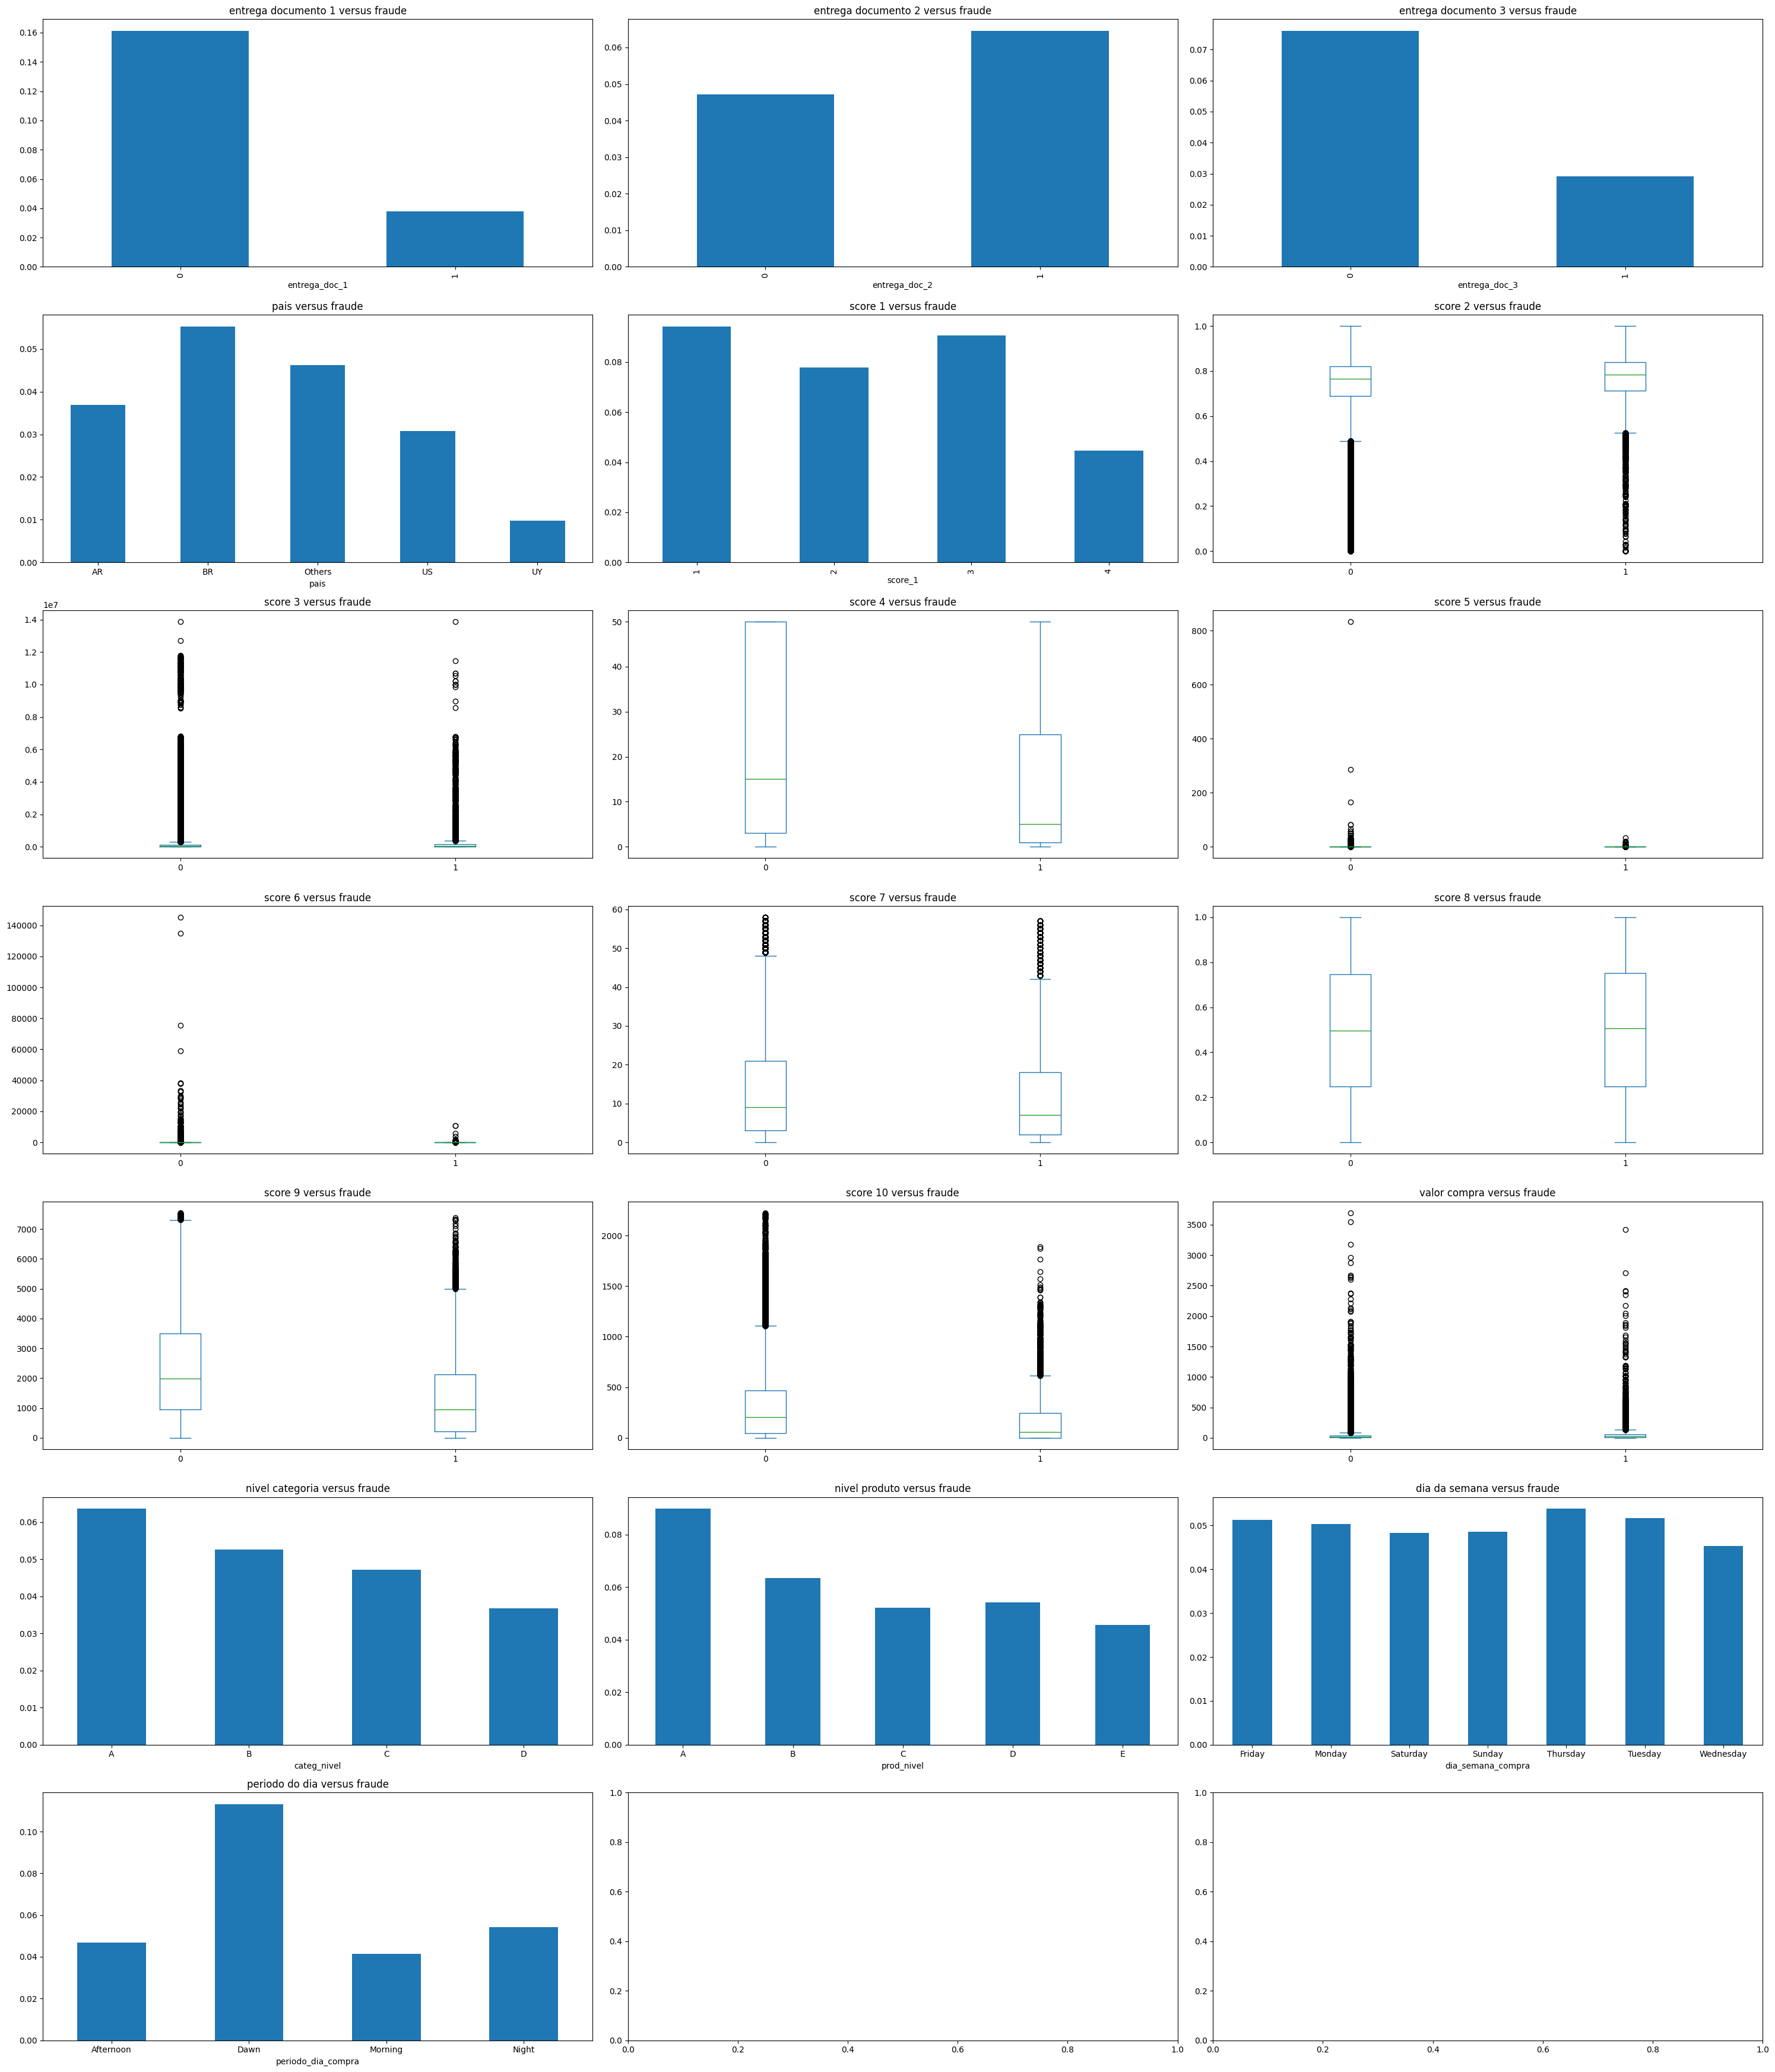

In [106]:

lines = 7
columns = 3
fig, axs = plt.subplots(lines, columns, figsize=(30, 5*lines))

df.groupby('entrega_doc_1')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 0])
axs[0, 0].set_title('entrega documento 1 versus fraude')

df.groupby('entrega_doc_2')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('entrega documento 2 versus fraude')

df.groupby('entrega_doc_3')['fraude'].mean().sort_index().plot.bar(ax=axs[0, 2])
axs[0, 2].set_title('entrega documento 3 versus fraude')

df.groupby('pais')['fraude'].mean().plot.bar(ax=axs[1, 0])
axs[1, 0].tick_params(axis='x', labelrotation=0)
axs[1, 0].set_title('pais versus fraude')

df.groupby('score_1')['fraude'].mean().sort_index().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('score 1 versus fraude')

df[['fraude','score_2']].plot.box(by='fraude', ax=axs[1, 2])
axs[1, 2].set_title('score 2 versus fraude')

df[['fraude','score_3']].plot.box(by='fraude', ax=axs[2, 0])
axs[2, 0].set_title('score 3 versus fraude')

df[['fraude','score_4']].plot.box(by='fraude', ax=axs[2, 1])
axs[2, 1].set_title('score 4 versus fraude')

df[['fraude','score_5']].plot.box(by='fraude', ax=axs[2, 2])
axs[2, 2].set_title('score 5 versus fraude')

df[['fraude','score_6']].plot.box(by='fraude', ax=axs[3, 0])
axs[3, 0].set_title('score 6 versus fraude')

df[['fraude','score_7']].plot.box(by='fraude', ax=axs[3, 1])
axs[3, 1].set_title('score 7 versus fraude')

df[['fraude','score_8']].plot.box(by='fraude', ax=axs[3, 2])
axs[3, 2].set_title('score 8 versus fraude')

df[['fraude','score_9']].plot.box(by='fraude', ax=axs[4, 0])
axs[4, 0].set_title('score 9 versus fraude')

df[['fraude','score_10']].plot.box(by='fraude', ax=axs[4, 1])
axs[4, 1].set_title('score 10 versus fraude')

df[['fraude','valor_compra']].plot.box(by='fraude', ax=axs[4, 2])
axs[4, 2].set_title('valor compra versus fraude')

df.groupby('categ_nivel')['fraude'].mean().sort_index().plot.bar(ax=axs[5, 0])
axs[5, 0].tick_params(axis='x', labelrotation=0)
axs[5, 0].set_title('nivel categoria versus fraude')

df.groupby('prod_nivel')['fraude'].mean().sort_index().plot.bar(ax=axs[5, 1])
axs[5, 1].tick_params(axis='x', labelrotation=0)
axs[5, 1].set_title('nivel produto versus fraude')

df.groupby('dia_semana_compra')['fraude'].mean().plot.bar(ax=axs[5, 2])
axs[5, 2].tick_params(axis='x', labelrotation=0)
axs[5, 2].set_title('dia da semana versus fraude')

df.groupby('periodo_dia_compra')['fraude'].mean().plot.bar(ax=axs[6, 0])
axs[6, 0].tick_params(axis='x', labelrotation=0)
axs[6, 0].set_title('periodo do dia versus fraude')

plt.tight_layout()
plt.show()

### **KPI**s

In [45]:
# 0) ganho por tempo ~ quanto, monetariamente estamos ganhando (ou perdendo) com o tempo (diariamente, mensalmente)
# 1) ganho total, perda total (ganho negativo) e ganho resultante total
# 2) qtde ganhos total, qtde perdas totais, qtde ganho resultante total
# 3) média ganho, perdas, ganho resultante (1 sobre 2)

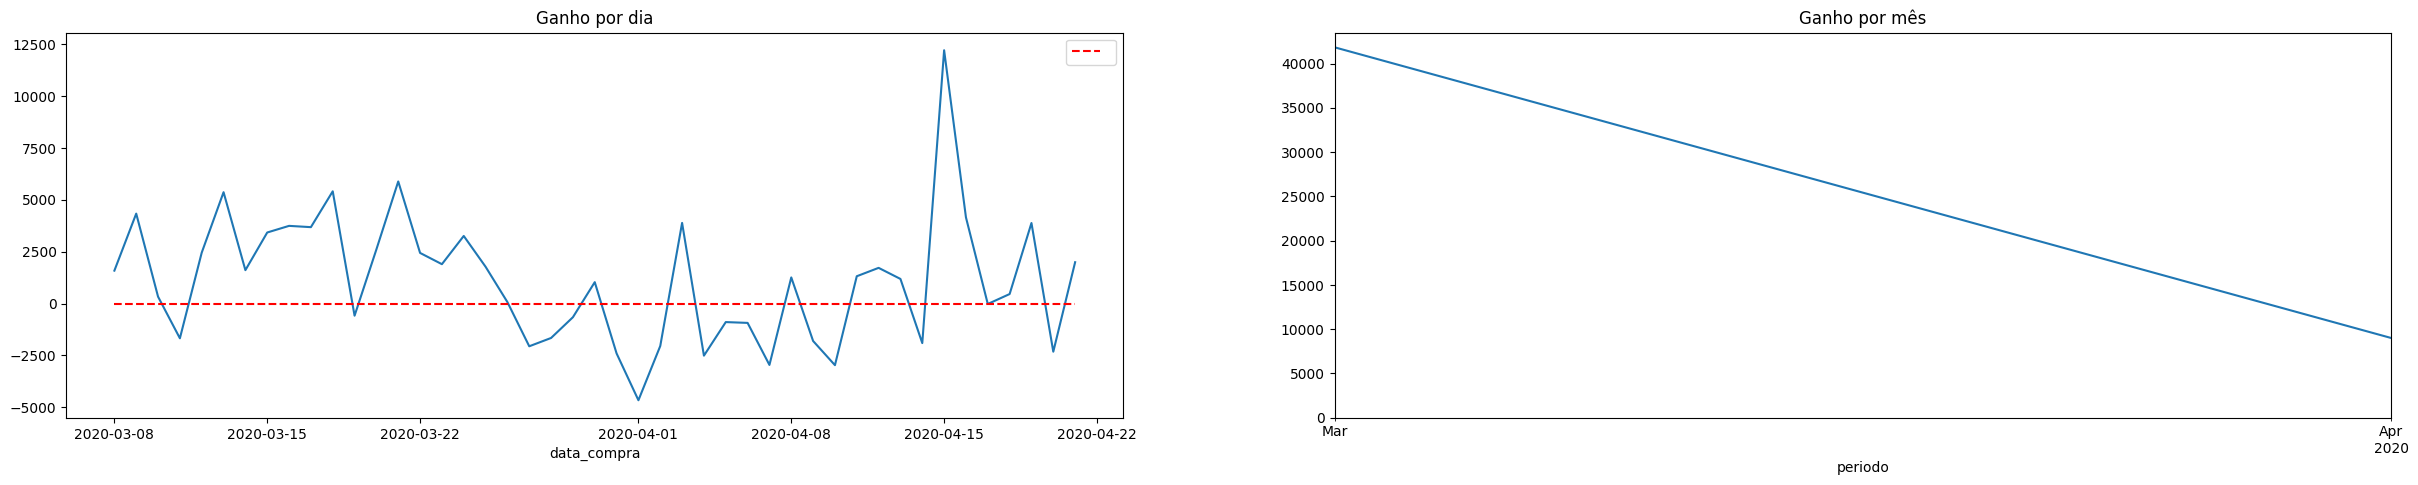

ganho total: 598119.8999999999, qtde: 142500, média, mediana: 4.197332631578947, 2.0180000000000002
perda total: -547271.1199999999, qtde: 7500, média, mediana: -72.96948266666665, -25.87
ganho resultante total: 50848.78000000003, qtde: 150000, média|mediana: 0.33899186666666686|1.8550000000000002

 DADOS AMOSTRAIS DE 2020-03-08 00:02:15 ATÉ 2020-04-21 23:59:56


In [66]:
# adicional futuro.: poderia existir uma analise do periodo atual versus perioso anterior para termos um insights melhores sobre melhora ou piora.

# 0)
fig, axs = plt.subplots(1, 2, figsize=(30, 5))

df.groupby('data_compra')['ganho'].sum().plot.line(ax=axs[0])
pd.DataFrame({'': [0]*len(df['data_compra'].unique())}, index=df['data_compra'].unique()).plot.line(color='r', linestyle='--', label='Threshold', ax=axs[0])
axs[0].set_title('Ganho por dia')

df.groupby('periodo')['ganho'].sum().plot.line(ax=axs[1])
axs[1].set_ylim(0)
axs[1].set_title('Ganho por mês')

plt.show()

# 1), 2) e 3)
print(f"ganho total: {df[df['ganho'] > 0]['ganho'].sum()}, qtde: {df[df['ganho'] > 0].shape[0]}, média, mediana: {df[df['ganho'] > 0]['ganho'].mean()}, {df[df['ganho'] > 0]['ganho'].median()}")
print(f"perda total: {df[df['ganho'] < 0]['ganho'].sum()}, qtde: {df[df['ganho'] < 0].shape[0]}, média, mediana: {df[df['ganho'] < 0]['ganho'].mean()}, {df[df['ganho'] < 0]['ganho'].median()}")
print(f"ganho resultante total: {df['ganho'].sum()}, qtde: {df.shape[0]}, média|mediana: {df['ganho'].mean()}|{df['ganho'].median()}")

print('\n', f"DADOS AMOSTRAIS DE {df['datahora_compra'].min()} ATÉ {df['datahora_compra'].max()}")

*insights:*
- no mês de março existem poucos dias finalizados negativamente, em abril dias finalizados no negativo são mais comuns - mais ainda no começo do mês.
- o ganho resultante foi menor em abril do que em março.
- dia 15/abril foi o recorde de ganho resultante positivo, que por si só "salvou" o mês de fechar em negativo.
- dia 01/abril (dia da mentira) foi o recorde de ganho resultante negativo.
- com os dados que temos, matematicamente em média, é preciso de 17 compras não fraudulentas para anular 1 compra fraudulenta. (se nossa amostra for representativa da população, i.e. sempre vão acontecer compras "iguais" então podemos esperar essa afirmação para o futuro).

In [47]:
# 1) quantidade de fraudes por tempo (e razão)
# 2) valor de compra de fraudes por tempo (e razão)
# 3) top 10 produtos produtos fraudados e sua razão de fraude

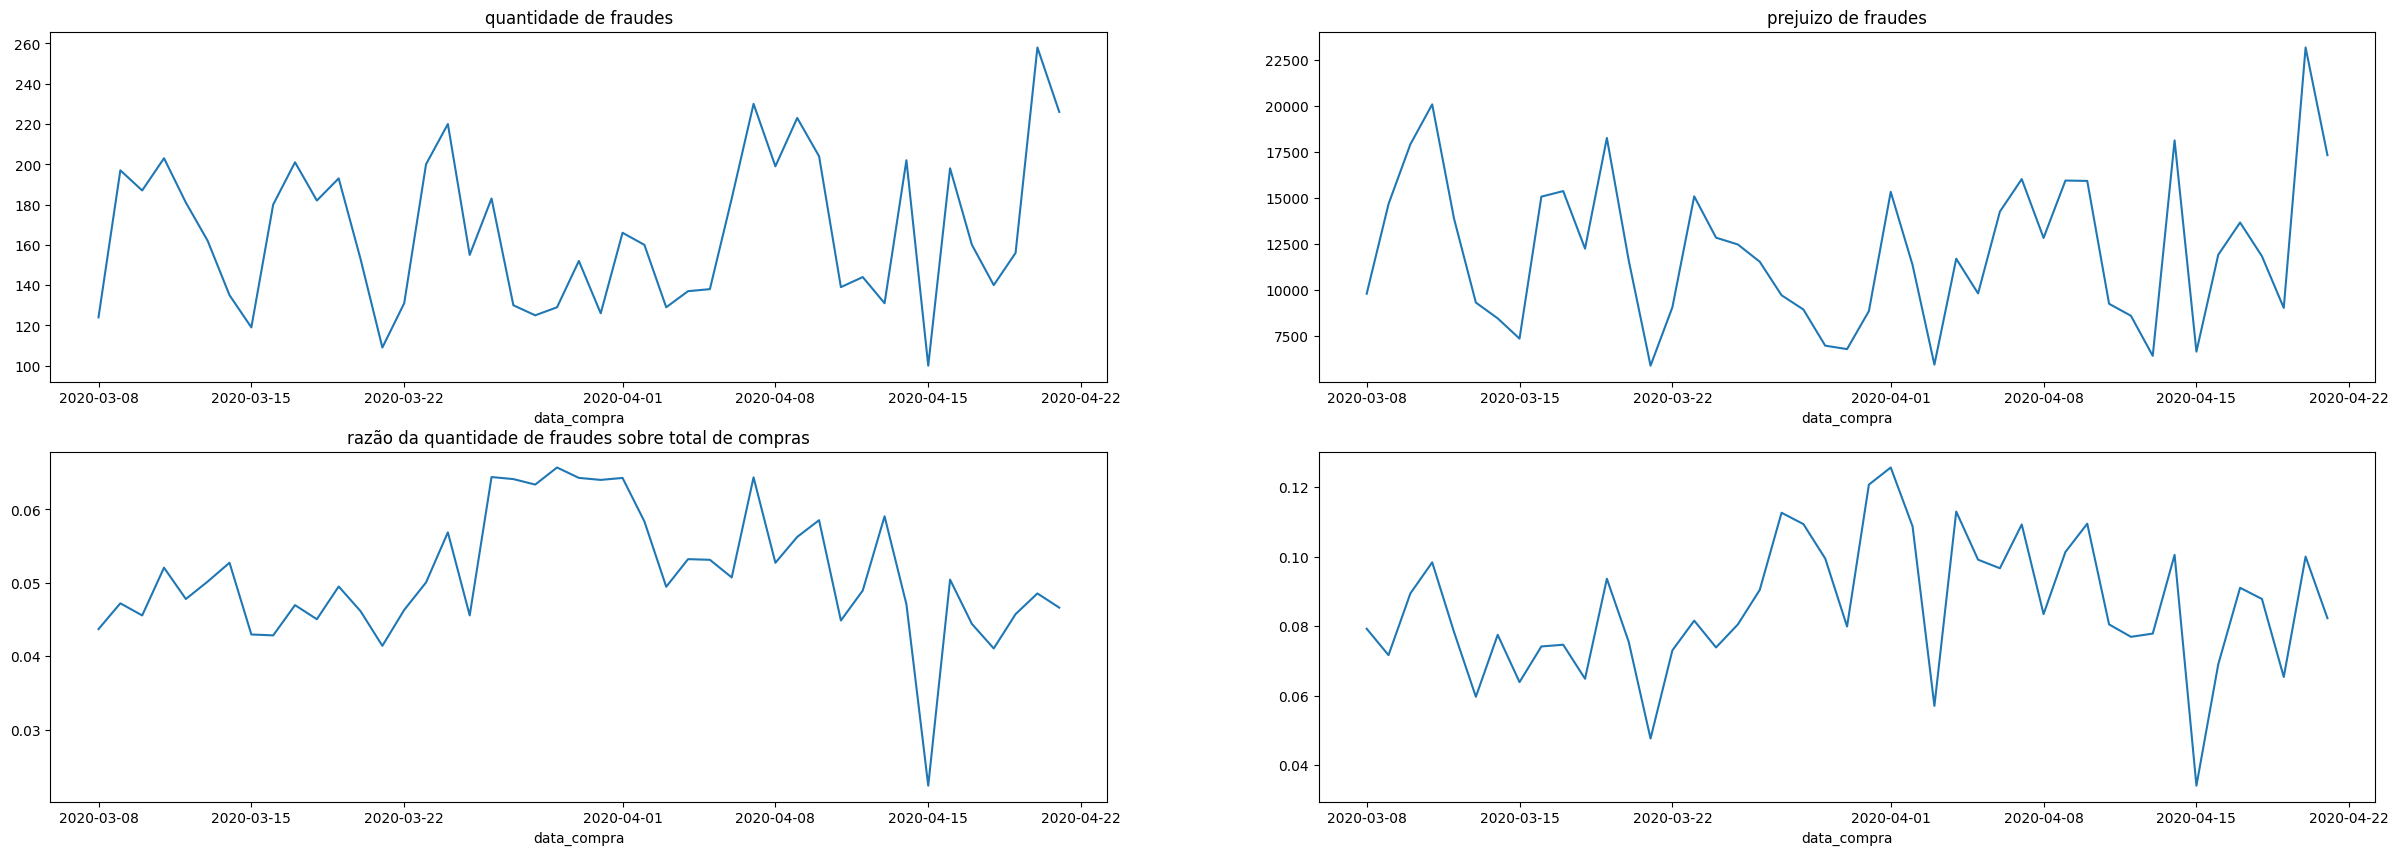

,sum,mean
produto,,
"Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m",44,0.936170
Bateria Moura 70 Amperes - Passat - Santana - Jeep,24,1.000000
Bola Oficial,22,1.000000
"Chaleira Elétrica Lenoxx 1,8 Litros Express Pce211",20,0.909091
Chaveiro Oficial Jr,17,1.000000
Samsung Galaxy A30s Dual Sim 64 Gb Prism Crush White 4 Gb Ram,11,0.366667
Curso Marcus Trombetta- A Riqueza Está Na Mente,10,1.000000
Amazon Gif,10,1.000000
Poster,10,1.000000



 DADOS AMOSTRAIS DE 2020-03-08 00:02:15 ATÉ 2020-04-21 23:59:56


In [67]:

fig, axs = plt.subplots(2, 2, figsize=(30, 10))

# 1)
df.groupby('data_compra')['fraude'].sum().plot.line(ax=axs[0, 0])
axs[0, 0].set_title('quantidade de fraudes')

df.groupby('data_compra')['fraude'].mean().plot.line(ax=axs[1, 0])
axs[1, 0].set_title('razão da quantidade de fraudes sobre total de compras')

# 2)
df[df['fraude']==1].groupby('data_compra')['valor_compra'].sum().plot.line(ax=axs[0, 1])
axs[0, 1].set_title('prejuizo de fraudes')

_df = pd.merge(df[df['fraude']==1].groupby('data_compra')['valor_compra'].sum().reset_index(name='prejuizo'), df.groupby('data_compra')['valor_compra'].sum().reset_index(), how='outer', on='data_compra')
_df.index = _df['data_compra']
_df = _df.drop('data_compra', axis=1)
(_df['prejuizo']/_df['valor_compra']).plot.line(ax=axs[1, 1])

plt.show()

# 3)
display(df.groupby('produto')['fraude'].agg(['sum','mean']).sort_values(by='sum', ascending=False).head(10))

print('\n', f"DADOS AMOSTRAIS DE {df['datahora_compra'].min()} ATÉ {df['datahora_compra'].max()}")

*insights:*
- a tendencia de fraudes em quantidade se manteve durante todo o tempo. (o mesmo comportamento acontece para fraudes em monetario).
- por dia, a proporção de fraudes em quantidade aumentou levemente em março e abaixou levemente em abril... voltando a proporção .045 atingida no começo de março. (o mesmo comportamento acontece para fraudes em monetario só que a proporção é de .08).
- existem alguns produtos com altissimas proporções de fraudes (alem de ser um produto que vende frequentemente).

**KPIs mais importantes:** ganho resultante total, ganho total e perda total.
- **estratégia:** maximizar o ganho total e minimizar a perda total a fim de maximizar o ganho resultante total (ganho resultante=ganho-perda).

**KPIs importantes *(com modelo de ML)*:** precission, recal, accuraccy, g = ganho resultante total (com modelo de ML) - ganho resultante total (sem modelo de ML) ~ se > 0: g é o GANHO que o modelo de ML traz, caso contrario: g é a PERDA.

###### *Respondido:* Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!; Como estão esses nossos KPIs atualmente?; Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer